# Анализ задачи предсказания результатов экзаменов учеников

### Импорт нужных библиотек и подгрузка БД

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import warnings; warnings.simplefilter('ignore')
sns.set()

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud = pd.read_csv('stud_math.csv')

### Объявляем функции

In [2]:
# Сокращатель value_counts по столбцу
def vcount(x):
    return stud[x].value_counts()


# Сокращатель median по столбцу
def med(x):
    return stud[x].median()


# Сокращатель mean по столбцу
def mea(x):
    return stud[x].mean()


# Считатель первого квартиля
def Q1(x):
    return x.quantile(0.25)


# Считатель третьего квартиля
def Q3(x):
    return x.quantile(0.75)


# Считатель межквартильного интервала
def IQR(x):
    return Q3(x) - Q1(x)


# Измеритель длины value_counts
def lenvc(x):
    return len(vcount(x))


# Сокращатель перевода в датафрейм
def pddf(x):
    return pd.DataFrame(x)


# Заменитель значений внутри столбца
def changev(col, value, tov):
    stud[col][stud[col] == value] = tov
    return


# Применятель определённой функции к каждому значению в столбце
def conv(col, oper):
    names = pddf(vcount(col)).index.tolist()
    for name in names:
        changev(col, name, oper(name))
    return


# Построитель графиков на весь датафрейм
def firstlook(df):
    stcol = df.columns.tolist()  # список столбцов
    columns = 2  # удобное число столбцов
    rows = len(stcol)//columns  # расчитываем число строк
    cou = 0  # счётчик для графиков

    # создаём поле с сабплотами
    fig, axes = plt.subplots(rows, columns, figsize=(12, 48))
    plt.subplots_adjust(top=2)

    for col in stcol:  # перебираем столбцы датафрейма
        # список по отдельным значениям столбца
        names = pd.DataFrame(df[col].value_counts()).index.tolist()
        # костыль: я принял, что у нас вряд ли есть больше 10 качеств в столбце
        if len(names) <= 10:
            for name in names:  # перебираем их
                # фильтруем по значению
                subset = df[df[col] == name]
                # рисуем денсити-плот по score из нашего фильтра
                sns.distplot(subset['score'], hist=False, kde=True,
                             kde_kws={'linewidth': 3},
                             label=name, ax=axes[cou // columns][cou % columns])
            # применяем название к сабплоту
            axes[cou // columns, cou % columns].set_title(col)
        elif len(names) > 10:
            # рисум одиночный денсити-плот по столбцу
            sns.distplot(subset[col], hist=False, kde=True,
                         kde_kws={'linewidth': 3},
                         label=col, ax=axes[cou // columns][cou % columns])
            # применяем название к сабплоту
            axes[cou // columns, cou % columns].set_title(col)
        # увеличиваем счётчик, чтобы отрисовать следующий сабплот
        cou += 1
    return


# Виртуальный датафрейм "score по критериям столбца"
def corrcol(df, col):
    # достаём качества из столбца
    names = pd.DataFrame(df[col].value_counts()).index.tolist()
    # создаем буферный список
    predata = []
    for name in names:  # перелистываем качества
        # создаём список значений score по качеству из основного датафрейма
        name = pd.DataFrame(df['score'][df[col] == name])['score'].tolist()
        # аппендим список значений в буферный список и получаем двухуровневый список
        predata.append(name)
    # транспонируем
    col = pd.DataFrame(predata).T
    # переименовываем столбцы
    col.columns = names
    return col  # возвращаем датафрейм


# Очиститель по качественности
def cleanqua(df):
    stcol = df.columns.tolist()  # список столбцов
    for colu in stcol:  # перебираем столбцы датафрейма
        # создаём список качеств внутри столбца
        names = pd.DataFrame(df[colu].value_counts()).index.tolist()
        # если количество качеств больше 10
        if len(names) > 10:
            # то удаляем столбец из списка
            stcol.remove(colu)
    return stcol


# Построитель heatmap по всему датафрейму
def heatmaps(df):
    stcol = df.columns.tolist()  # список столбцов
    columns = 2  # удобное число столбцов
    rows = int(round(len(stcol))/columns - (len(stcol)-len(cleanqua(stud))))  # расчитываем число строк
    cou = 0  # счётчик для графиков

    # создаём поле с сабплотами
    fig, axes = plt.subplots(rows, columns, figsize=(12, 48))
    plt.subplots_adjust(top=2)

    for col in stcol:  # снова перебираем столбцы датафрейма
        # создаём список качеств внутри столбца
        names = pd.DataFrame(df[col].value_counts()).index.tolist()
        # если количество качеств больше 10, то скипаем
        if len(names) > 10:
            continue
        # иначе строим heatmap
        else:
            sns.heatmap(corrcol(df, col).describe(), annot=True,
                        cmap="viridis", ax=axes[cou // columns][cou % columns])
            # применяем название к сабплоту
            axes[cou // columns][cou % columns].set_title(col)
            # наращиваем счётчик сабплота
            cou += 1
    return

### Смотрим на саму БД

In [3]:
display(stud.sample(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
323,GP,F,17,U,GT3,T,3.0,1.0,services,services,course,father,1.0,3.0,0.0,no,yes,no,no,no,-9.0,yes,yes,no,NaN,4.0,3.0,5.0,1.0,75.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
189,GP,M,17,R,GT3,T,1.0,2.0,at_home,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,no,no,3.0,1.0,3.0,NaN,4.0,50.0
165,GP,M,16,U,GT3,T,3.0,2.0,services,services,course,mother,2.0,1.0,1.0,no,yes,no,yes,no,-3.0,no,no,no,4.0,5.0,2.0,2.0,16.0,60.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,-3.0,yes,NaN,no,NaN,3.0,3.0,5.0,2.0,70.0
350,MS,M,19,NaN,GT3,T,1.0,1.0,other,services,home,other,3.0,2.0,3.0,no,no,no,no,NaN,-6.0,yes,yes,no,5.0,4.0,4.0,2.0,8.0,NaN
344,GP,F,18,U,NaN,T,2.0,3.0,at_home,other,course,NaN,1.0,3.0,NaN,no,yes,no,no,yes,-9.0,yes,yes,no,4.0,3.0,3.0,3.0,4.0,50.0
210,GP,F,19,U,GT3,NaN,3.0,3.0,other,other,reputation,other,1.0,4.0,0.0,no,yes,yes,yes,yes,-12.0,yes,yes,no,4.0,3.0,3.0,3.0,10.0,40.0
106,GP,F,15,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,no,5.0,1.0,2.0,3.0,8.0,40.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Инфо говорит, что в ней 17 строковых и 13 числовых столбцов. Но при взгляде на таблицу видно, что истинно числовых в ней только score и absences. Остальные по сути своей категорийные.
Всего строк 395, в которых заполнены от 350 (Pstatus) до 395 (например, school) значений.

### Предварительная очистка

Пустых значений в столбце score меньше двух процентов.
Сам столбец score я считаю целевым (следовательно не стал бы как-либо искажать значения в нём).

Поэтому мне кажется наиболее разумным отфильтровать данные так, чтобы исключить отсутствующие данные в столбце.

In [4]:
stud = stud[stud.score.isnull() == False]

### Первичный отсмотр

Опытным путём избрал денсити-плот как самый визуальный для меня. Читать боксплоты и виолинплоты мне оказалось тяжело.

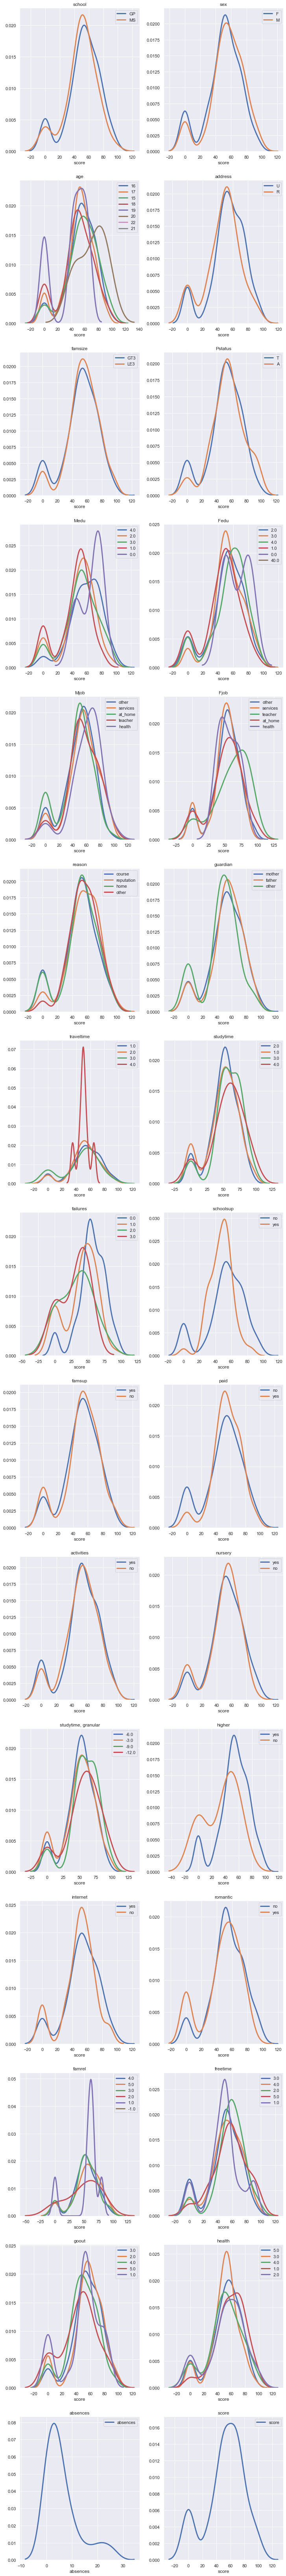

In [5]:
firstlook(stud)

В целом здесь видно, что у ряда качественных переменных графики не сильно отличаются от "качества".

Так же видно две чётких ошибки в Fedu (я уверен, что 40 это 4) и famrel (я уверен, что -1 это 1). Заменяю.

In [6]:
changev('Fedu', 40.0, 4.0)
changev('famrel', -1.0, 1.0)

Плюс какая-то странная история с traveltime. Надо глянуть подробнее.

In [7]:
corrcol(stud, 'traveltime').describe()

,1.0,2.0,3.0,4.0
count,239.000000,94.000000,21.000000,7.000000
mean,53.577406,51.755319,46.428571,50.000000
std,22.794876,21.486523,26.558561,9.128709
min,0.000000,0.000000,0.000000,35.000000
25%,45.000000,41.250000,40.000000,47.500000
50%,55.000000,50.000000,50.000000,50.000000
75%,70.000000,65.000000,65.000000,52.500000
max,100.000000,95.000000,90.000000,65.000000


Полагаю, это связано с тем, что внутри качества "4.0" всего семь значений. Чем можно заменить пропуски, чтоб было статистически верно не знаю.

Ну и конечно "0" в графе score.

In [8]:
stud[stud.score == 0]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,-9.0,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,NaN,no,yes,-6.0,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,-3.0,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,-6.0,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


Мне кажется странным, что у тех, у кого ноль баллов, так же и ноль пропусков, поголовно. Так что в данном случае ноль не кажется мне оценкой показывающей успеваемость. С другой стороны количество пропусков может не влиять на оценку.

### Корреляционный анализ числовых переменных

Попробую измерить корреляцию между пропусками и оценкой. Без фильтрации и с отсечением двух предположительных выбросов.

In [9]:
st_temp = stud[stud.absences < 200]
display('filter none',stud.loc[:,['absences','score']].corr())
display('filter < 200',st_temp.loc[:,['absences','score']].corr())

'filter none'

,absences,score
absences,1.000000,0.065283
score,0.065283,1.000000


'filter < 200'

,absences,score
absences,1.000000,0.031698
score,0.031698,1.000000


Есть очень слабая положительная корреляция. В обоих случаях, разница между случаями очень невысока.
Делаю вывод о том, что скрипач не нужен.

### Анализ качественных переменных

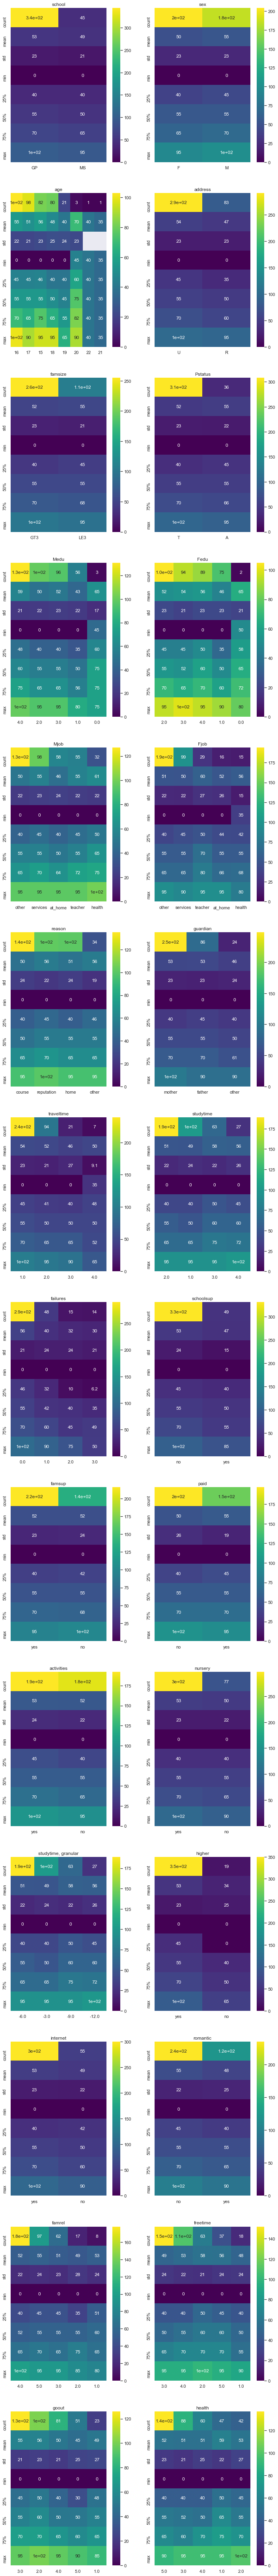

In [10]:
heatmaps(stud)

Судя по heatmap, столбцы имеющие значение это: age, Medu, Fedu, Mjob, Fjob, reason, studytime, studytime granular (который тождественнен studytime), famrel, freetime, goout, health.
Я понимаю, что этот способ далёк от совершенства, но он мне понятен и времени изобретать что-то поинтереснее у меня уже N-1.

### Выводы

* Данных бы больше, 400 строк маловато.
* Обилие пропусков в тех графах, значения которых не касается ученика напрямую, а касается его семьи.
* Обилие категорийных совершенно неисчисляемых переменных. Совершенно неясно на что менять пропуски в этих случаях, а просто удалить нельзя.
* Странный 0 по `score`, который присутствует практически во всех категориях. На выброс не похож.
* Столбцы достойные внимания это: `age`, `Medu`, `Fedu`, `Mjob`, `Fjob`, `reason`, `studytime`, `famrel`, `freetime`, `goout`, `health`. Что отлично видно и по densityplot и по heatmap.
* Итогом я считаю, что на данный момент данные грязноваты. Либо больше выборку, либо более качественный сбор.